In [1]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from scipy import interp
import matplotlib.pyplot as plt

def plotCVROC(PredictorsDF,ResponseDF,model,foldN):
    """ 
    PredictorsDF and ResponseDF is a dataframe of predictors and response, respectively.
    Model
    foldN is the number of fold used in cross validation.
    """
    X = PredictorsDF.values
    y = ResponseDF.values

    
    n_samples, n_features = X.shape

    # Add noisy features
    random_state = np.random.RandomState(0)
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=foldN)


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10,10))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()

In [2]:
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('heart_disease_clean.csv')
df.head()

,Unnamed: 0,age,resting_blood_pressure,cholesterol,max_heart_rate,ST_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,...,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/dl,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_indeced_angina_Yes,ST_slope_flat,ST_slope_upsloping,thalassemia_normal,thalassemia_reversable defect,thalassemia_unknown
0,0,63,145,233,150,2.3,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
1,1,37,130,250,187,3.5,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2,2,41,130,204,172,1.4,0,1,0,0,...,1,1,0,1,0,1,0,0,0,0
3,3,56,120,236,178,0.8,0,1,1,0,...,1,1,0,0,0,1,0,0,0,0
4,4,57,120,354,163,0.6,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0


In [4]:
df = pd.get_dummies(df,drop_first=True)
df.shape

(303, 21)

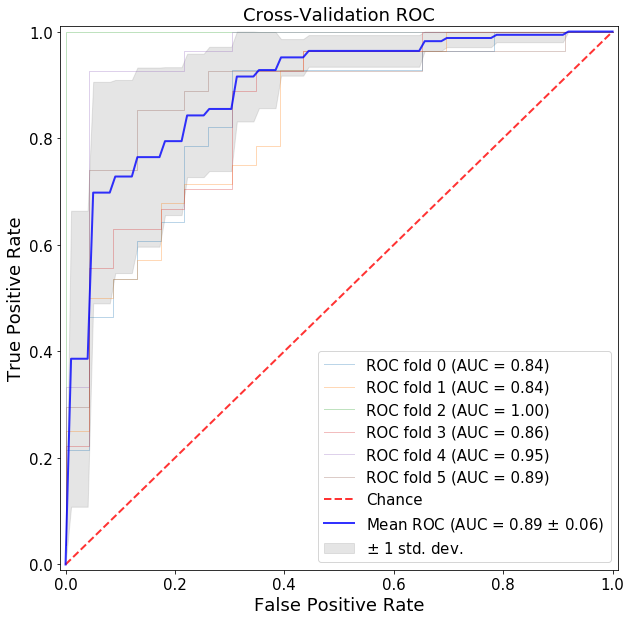

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = df.drop('target',1)
y = df['target']

model = make_pipeline(RobustScaler(),
                   RandomForestClassifier(max_depth=5,criterion='entropy',n_estimators=100))

plotCVROC(X,y,model,6)